In [2]:
!pip install ultralytics -q
print("Ultralytics package installed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s eta 0:00:00
Ultralytics package installed.


In [3]:
import os
from google.colab import drive

# --- 1. Reset to a safe, default directory ---
os.chdir('/content/')
print(f"Reset directory to: {os.getcwd()}")

# --- 2. Re-mount your Drive ---
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Drive mounted successfully.")

# --- 3. Set Up Project Directory & Unzip Data ---
project_dir = "/content/drive/MyDrive/SafetyEye"
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print(f"Changed directory to: {os.getcwd()}")

# --- 4. Unzip (using the correct filename) ---
zip_file_name = 'archive (2).zip'
data_folder_name = 'css-data'

if not os.path.exists(data_folder_name):
    if os.path.exists(zip_file_name):
        print(f"Unzipping {zip_file_name}...")
        !unzip -q -o "{zip_file_name}"
        print("Dataset unzipped.")
    else:
        print(f"ERROR: Cannot find {zip_file_name} in {project_dir}")
else:
    print(f"Data folder '{data_folder_name}' already exists.")

print("\n--- Setup is complete. ---")

Reset directory to: /content
Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.
Changed directory to: /content/drive/MyDrive/SafetyEye
Data folder 'css-data' already exists.

--- Setup is complete. ---


In [4]:
import os
from pathlib import Path

print("--- Starting Dataset Cleaning (Task 1 - Clean Script) ---")
data_path = Path('css-data')
sets_to_clean = ['train', 'valid']
total_removed = 0

for s in sets_to_clean:
    labels_dir = data_path / s / 'labels'
    images_dir = data_path / s / 'images'

    empty_label_files = [
        f for f in labels_dir.glob('*.txt') if f.stat().st_size == 0
    ]

    count_in_set = 0
    if not empty_label_files:
        print(f"No empty label files found in '{s}' set.")
        continue

    print(f"Found {len(empty_label_files)} empty labels in '{s}'. Removing them and their images...")

    for label_file in empty_label_files:
        file_stem = label_file.stem

        # Find the matching image file (e.g., .jpg, .png, .jpeg)
        image_files = list(images_dir.glob(f"{file_stem}.*"))

        if image_files:
            image_file = image_files[0] # Get the first match

            # Delete both files
            os.remove(label_file)
            os.remove(image_file)
            count_in_set += 1
            total_removed += 1

    print(f"Removed {count_in_set} files from '{s}' set.")

print(f"--- Cleaning Complete: Removed {total_removed} total empty/background images. ---")

--- Starting Dataset Cleaning (Task 1 - Clean Script) ---
No empty label files found in 'train' set.
No empty label files found in 'valid' set.
--- Cleaning Complete: Removed 0 total empty/background images. ---


In [5]:
import os
from pathlib import Path


data_path = Path('css-data')
sets_to_check = ['train', 'valid']
errors_found = False

for s in sets_to_check:
    print(f"Checking '{s}' set...")
    image_files = set(p.stem for p in (data_path / s / 'images').glob('*'))
    label_files = set(p.stem for p in (data_path / s / 'labels').glob('*.txt'))

    # Check 1: Images without labels
    missing_labels = image_files - label_files
    if missing_labels:
        errors_found = True
        print(f"   ERROR: {len(missing_labels)} images have no .txt label file. Example: {list(missing_labels)[0]}")

    missing_images = label_files - image_files
    if missing_images:
        errors_found = True
        print(f"   ERROR: {len(missing_images)} .txt label files have no image. Example: {list(missing_images)[0]}")

    empty_labels = []
    for label_file in (data_path / s / 'labels').glob('*.txt'):
        if label_file.stat().st_size == 0:
            empty_labels.append(label_file.name)

    if empty_labels:
        errors_found = True
        print(f"   ERROR: {len(empty_labels)} .txt label files are empty. Example: {empty_labels[0]}")

if not errors_found:
    print(" Data Validation Passed: All files match.")


Checking 'train' set...
Checking 'valid' set...
 Data Validation Passed: All files match.


In [6]:
import os


config_file_path = 'safetyeye_config.yaml'

abs_data_path = os.path.abspath('css-data')


yaml_content = f"""
train: {os.path.join(abs_data_path, 'train/images')}
val: {os.path.join(abs_data_path, 'valid/images')}
test: {os.path.join(abs_data_path, 'test/images')}

nc: 10

names:
  0: Hardhat
  1: Mask
  2: NO-Hardhat
  3: NO-Mask
  4: NO-Safety Vest
  5: Person
  6: Safety Cone
  7: Safety Vest
  8: machinery
  9: vehicle
"""

with open(config_file_path, 'w') as f:
    f.write(yaml_content)

print(f"Correct config file '{config_file_path}' created.")
print("--- Verifying Config Contents: ---")
!cat {config_file_path}

Correct config file 'safetyeye_config.yaml' created.
--- Verifying Config Contents: ---

train: /content/drive/MyDrive/SafetyEye/css-data/train/images
val: /content/drive/MyDrive/SafetyEye/css-data/valid/images
test: /content/drive/MyDrive/SafetyEye/css-data/test/images

nc: 10

names:
  0: Hardhat
  1: Mask
  2: NO-Hardhat
  3: NO-Mask
  4: NO-Safety Vest
  5: Person
  6: Safety Cone
  7: Safety Vest
  8: machinery
  9: vehicle


In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

print("--- Starting Visual Demo (Image) ---")

# 1. Define paths
model_path = 'SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt'
test_images_dir = 'css-data/test/images/'

# 2. Check if model exists
if not os.path.exists(model_path):
    print(f"ERROR: Cannot find model at {model_path}")
else:
    # 3. Get a random test image
    test_images = os.listdir(test_images_dir)
    random_image = random.choice(test_images)
    image_path = os.path.join(test_images_dir, random_image)

    print(f"Loading model: {model_path}")
    print(f"Running inference on: {image_path}")

    # 4. Load the model (will run on CPU)
    model = YOLO(model_path)

    # 5. Run inference and save the result
    # We'll save the result to a new folder to see it
    results = model.predict(image_path, save=True, project='SafetyEye_Project_Run', name='demo_outputs')

    print("\n--- Inference Complete ---")
    print(f"Result saved to: {results[0].save_dir}")

    # 6. Display the saved image
    display_image_path = os.path.join(results[0].save_dir, random_image)
    display(Image(filename=display_image_path))from ultralytics import YOLO

print("\n--- Starting Initial Training (Task 3) ---")
print("Loading base model 'yolov8n.pt'...")
model = YOLO('yolov8n.pt')

print("Starting model training (This will take a while)...")
results = model.train(
    data='safetyeye_config.yaml',    # Use the config file we just made
    epochs=50,                      # 50 training cycles
    imgsz=640,                      # Image size
    project='SafetyEye_Project_Run', # Main project folder for all runs
    name='initial_50_epoch_run'   # Specific name for this experiment
)

print("Training complete!")
print(f"Results saved to: {results.save_dir}")

SyntaxError: invalid syntax (ipython-input-2122811615.py, line 36)

--- Displaying Training Results (Task 4) ---


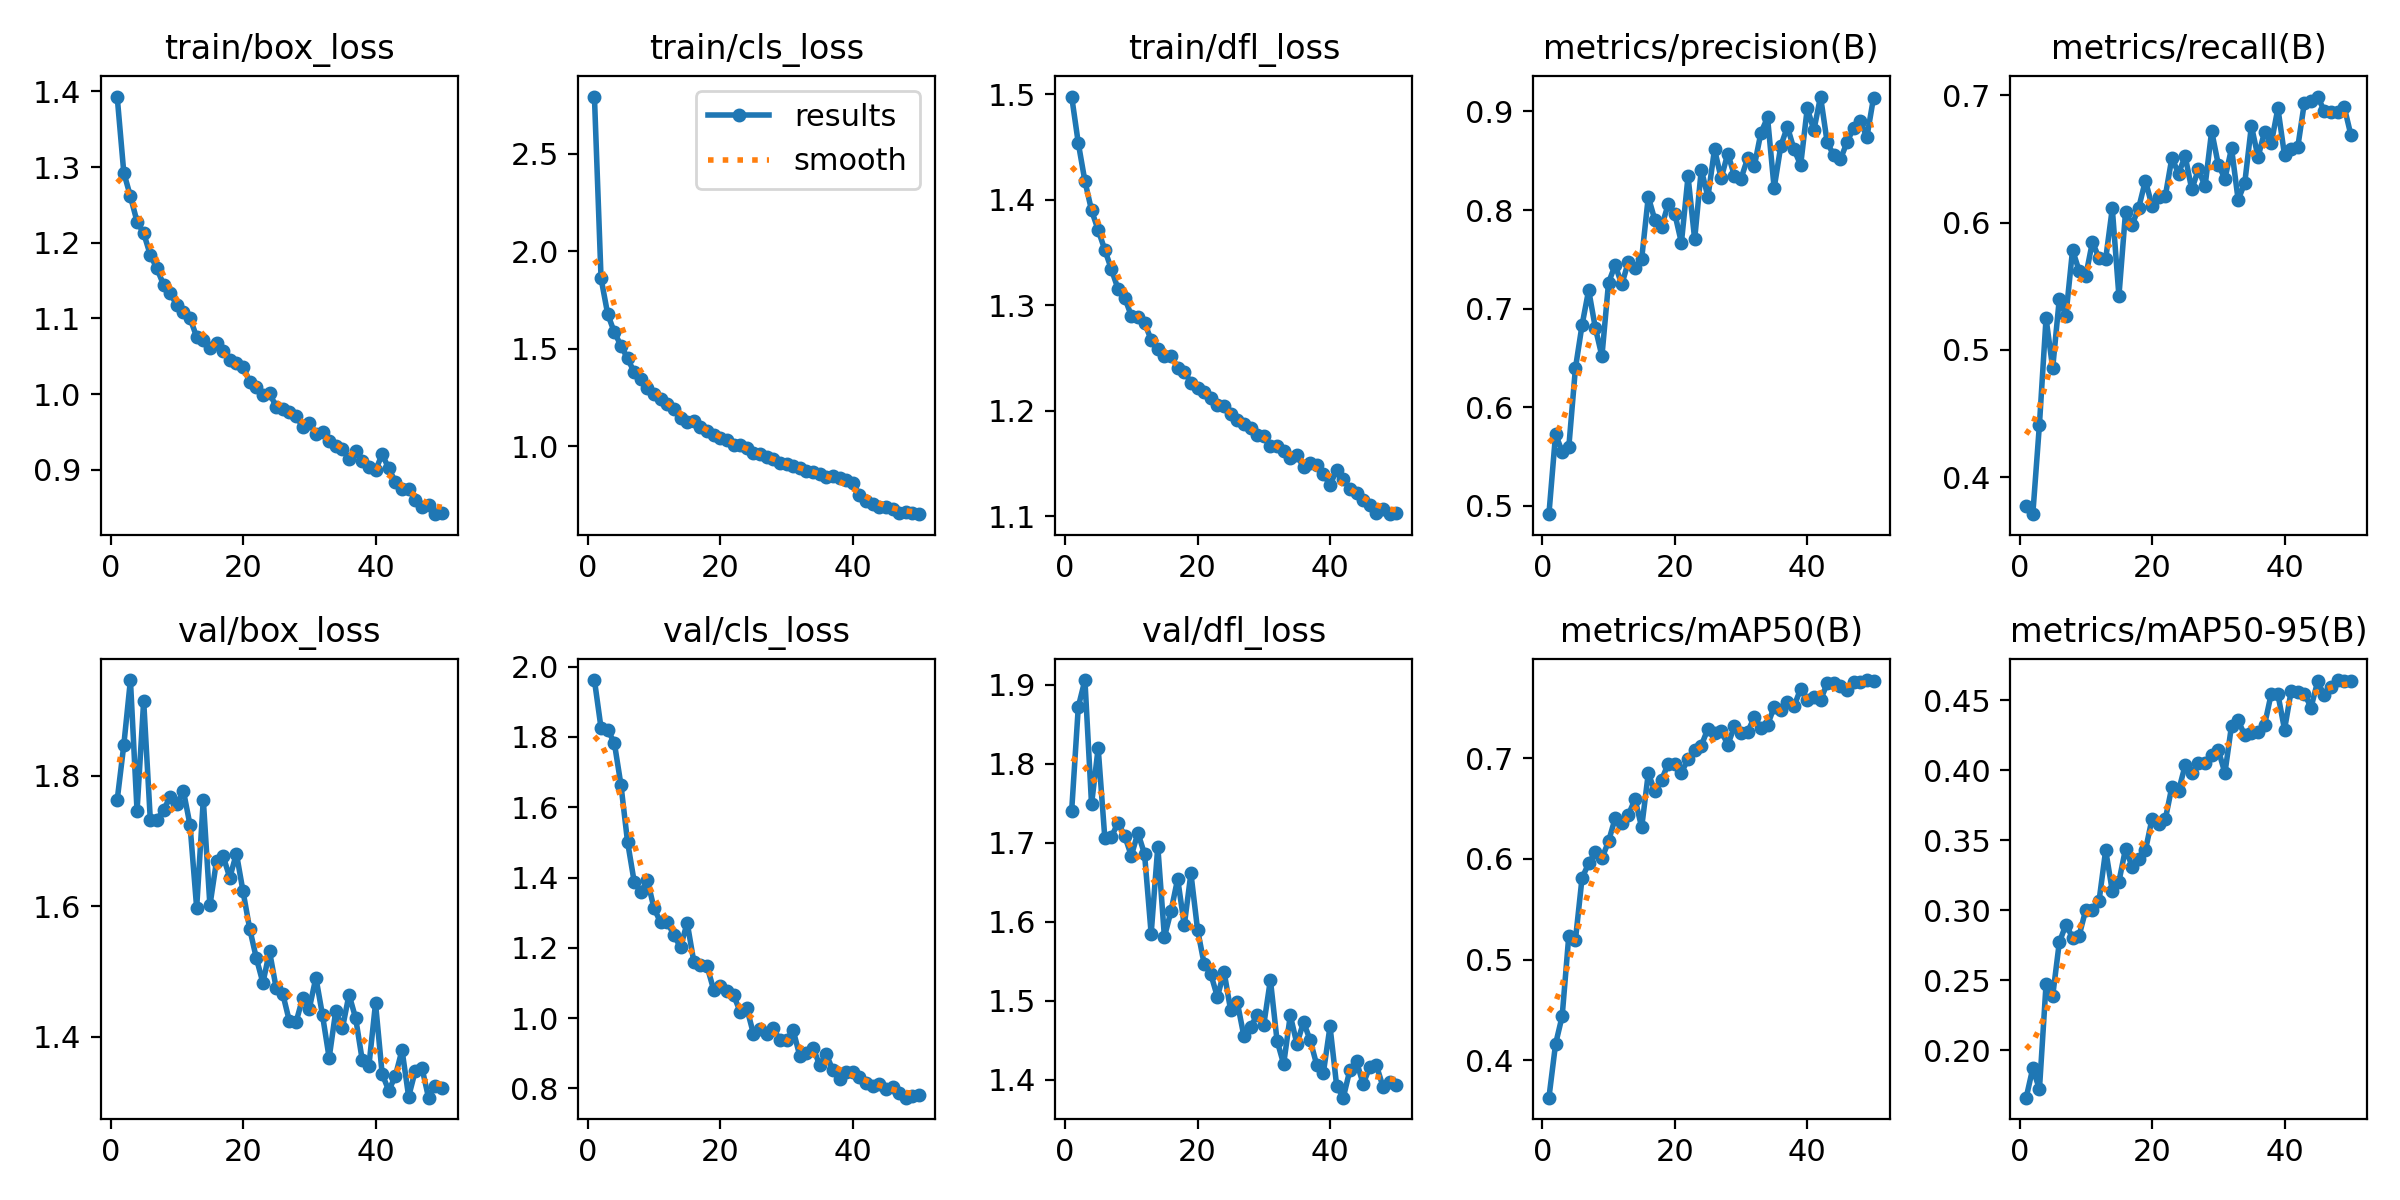

In [ ]:
from IPython.display import Image

# This finds the results.png file from the run we just completed
results_path = 'SafetyEye_Project_Run/initial_50_epoch_run/results.png'

if os.path.exists(results_path):
    print("--- Displaying Training Results (Task 4) ---")
    # Display the image in the notebook
    display(Image(filename=results_path))
else:
    print(f"ERROR: Could not find results.png at {results_path}")

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
print("Starting model training...")
results_aug = model.train(
    data='safetyeye_config.yaml',    # Use the same config file
    epochs=50,                      # Same number of epochs
    imgsz=640,                      # Same image size
    project='SafetyEye_Project_Run', # Save to our main project folder
    name='run_with_augmentation',   # *** NEW: Save to a new folder ***

    # --- NEW: Data Augmentation Arguments ---
    fliplr=0.5,   # Randomly flip images horizontally (50% chance)
    mosaic=1.0,   # Creates a 4-image mosaic (standard augmentation)
    hsv_h=0.015,  # Adjust image Hue (color)
    hsv_s=0.7,    # Adjust image Saturation (color intensity)
    hsv_v=0.4     # Adjust image Value (brightness)
)

print(" Augmentation training complete!")
print(f"Results saved to: {results_aug.save_dir}")

In [ ]:
!rm -rf /content/drive

--- Starting Visual Demo (Image) ---
Loading model: SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt
Running inference on: css-data/test/images/ppe_0018_jpg.rf.be66fabcc8627f60d963454b5a227095.jpg

image 1/1 /content/drive/My Drive/SafetyEye/css-data/test/images/ppe_0018_jpg.rf.be66fabcc8627f60d963454b5a227095.jpg: 640x640 2 Hardhats, 2 NO-Masks, 2 NO-Safety Vests, 2 Persons, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/demo_outputs16

--- Inference Complete ---
Result saved to: /content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/demo_outputs16


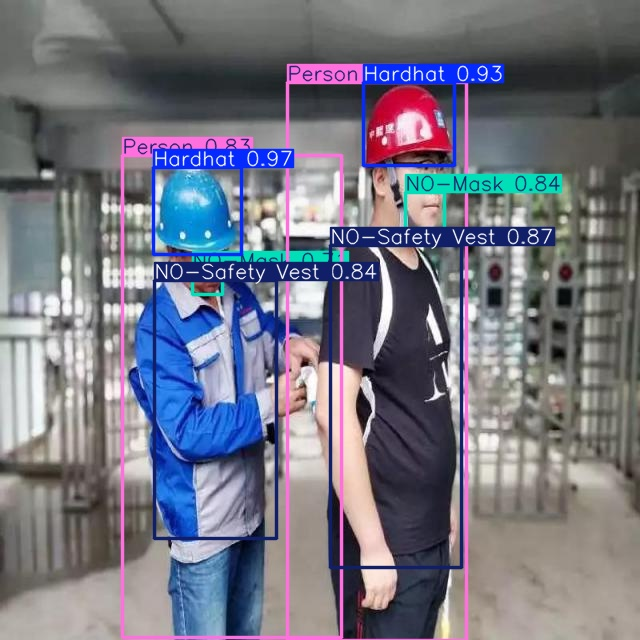

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import os
import random

print("--- Starting Visual Demo (Image) ---")

# 1. Define paths
model_path = 'SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt'
test_images_dir = 'css-data/test/images/'

# 2. Check if model exists
if not os.path.exists(model_path):
    print(f"ERROR: Cannot find model at {model_path}")
else:
    # 3. Get a random test image
    test_images = os.listdir(test_images_dir)
    random_image = random.choice(test_images)
    image_path = os.path.join(test_images_dir, random_image)

    print(f"Loading model: {model_path}")
    print(f"Running inference on: {image_path}")

    # 4. Load the model (will run on CPU)
    model = YOLO(model_path)

    # 5. Run inference and save the result
    # We'll save the result to a new folder to see it
    results = model.predict(image_path, save=True, project='SafetyEye_Project_Run', name='demo_outputs')

    print("\n--- Inference Complete ---")
    print(f"Result saved to: {results[0].save_dir}")

    # 6. Display the saved image
    display_image_path = os.path.join(results[0].save_dir, random_image)
    display(Image(filename=display_image_path))

In [ ]:
from ultralytics import YOLO
import os

print("--- Starting Visual Demo (Video) ---")

# 1. Define paths
model_path = 'SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt'

# --- EDIT THIS LINE ---
# Add the correct extension (like .mp4 or .avi) to your video file name
video_path = '853867-hd_1920_1080_25fps.mp4'
# ----------------------

output_dir = 'SafetyEye_Project_Run/demo_outputs'

# 2. Check if files exist
if not os.path.exists(model_path):
    print(f"ERROR: Cannot find model at {model_path}")
elif not os.path.exists(video_path):
    print(f"ERROR: Cannot find video at {video_path}")
    print("Please make sure the filename and extension are correct.")
else:
    print(f"Loading model: {model_path}")
    print(f"Running inference on: {video_path}")

    # 3. Load the model
    model = YOLO(model_path)

    # 4. Run inference on the video
    # This will be slow on a CPU, but it will work.
    # It saves the result to the 'demo_outputs' folder.
    results = model.predict(
        video_path,
        save=True,
        project='SafetyEye_Project_Run',
        name='demo_outputs'
    )

    print("\n--- Video Processing Complete ---")
    print(f"Output video saved in: {output_dir}")

--- Starting Visual Demo (Video) ---
Loading model: SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt
Running inference on: 853867-hd_1920_1080_25fps.mp4

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/388) /content/drive/MyDrive/SafetyEye/853867-hd_1920_1080_25fps.mp4: 384x640 3 Hardhats, 4 Persons, 1 Safety Cone, 4 Safety Vests, 2 machinerys, 72.3ms
video 1/1 (frame 2/388) /content/drive/MyDrive/SafetyEye/853867-hd_1920_1080_25fps.mp4: 384x640 4 Hardhats, 4 Persons, 1 S

In [ ]:
from ultralytics import YOLO

print("--- Starting Hyperparameter Tuning Experiment (Exp 1) ---")

model = YOLO('yolov8n.pt')

results_exp1 = model.train(
    data='safetyeye_config.yaml',
    epochs=50,
    imgsz=640,
    project='SafetyEye_Project_Run',
    name='tuning_exp_batch32_lr_lower',
    batch=32,
    lr0=0.005
)

print(f"Tuning Experiment 1 saved to: {results_exp1.save_dir}")

In [ ]:
import os
import shutil
from ultralytics import YOLO

BEST_RUN_PATH = 'SafetyEye_Project_Run/tuning_exp_batch32_lr_lower/'
BEST_MODEL_SOURCE = os.path.join(BEST_RUN_PATH, 'weights/best.pt')
FINAL_EXPORT_DIR = 'SafetyEye_Project_Run/models/best_model/'
FINAL_MODEL_DEST = os.path.join(FINAL_EXPORT_DIR, 'best.pt')

if not os.path.exists(BEST_MODEL_SOURCE):
    print(f"ERROR: Best model not found at {BEST_MODEL_SOURCE}")
else:
    os.makedirs(FINAL_EXPORT_DIR, exist_ok=True)
    shutil.copy(BEST_MODEL_SOURCE, FINAL_MODEL_DEST)

    print(f"Best model exported and saved to: {FINAL_MODEL_DEST}")

    model_final = YOLO(FINAL_MODEL_DEST)
    print("Verification: Model loaded successfully for inference.")

Best model exported and saved to: SafetyEye_Project_Run/models/best_model/best.pt
Verification: Model loaded successfully for inference.


In [ ]:
import os
import shutil
from ultralytics import YOLO

BEST_RUN_PATH = 'SafetyEye_Project_Run/tuning_exp_batch32_lr_lower/'
BEST_MODEL_SOURCE = os.path.join(BEST_RUN_PATH, 'weights/best.pt')
FINAL_EXPORT_DIR = 'SafetyEye_Project_Run/models/best_model/'
FINAL_MODEL_DEST = os.path.join(FINAL_EXPORT_DIR, 'best.pt')

if not os.path.exists(BEST_MODEL_SOURCE):
    print(f"ERROR: Source model not found at {BEST_MODEL_SOURCE}. Did tuning run?")
else:
    os.makedirs(FINAL_EXPORT_DIR, exist_ok=True)
    shutil.copy(BEST_MODEL_SOURCE, FINAL_MODEL_DEST)
    print(f"Best model exported and saved to: {FINAL_MODEL_DEST}")

Best model exported and saved to: SafetyEye_Project_Run/models/best_model/best.pt


In [ ]:
import os
# Verify the contents of the mounted drive directory
print("Files in Google Drive root:", os.listdir('/content/drive/My Drive'))

Files in Google Drive root: ['Week1_Code_Explanation_AsciiSafe.pdf', 'Week1_Milestone1_Notes (1).pdf', 'Colab Notebooks', 'kaggle', 'Untitled0.ipynb', 'archive (1).zip', 'SafetyEye']


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Define the path to your project folder
project_path = "/content/drive/My Drive/SafetyEye"

# Change the current working directory
os.chdir(project_path)

# Print the current directory to confirm
print(f"Current directory: {os.getcwd()}")

# List the files and folders inside your project directory
print("\nContents of SafetyEye:")
print(os.listdir('.'))

Current directory: /content/drive/My Drive/SafetyEye

Contents of SafetyEye:
['archive (2).zip', 'css-data', 'results_yolov8n_100e', 'source_files', 'yolov8n.pt', 'SafetyEye_Project_Run', 'yolo11n.pt', '853867-hd_1920_1080_25fps.mp4', 'text_video.mp4', 'runs', 'safetyeye_config.yaml']


In [ ]:
pip install ultralytics opencv-python pandas

In [ ]:
from ultralytics import YOLO
import yaml

# --- 1. Load Your Model ---
model_path = "yolov8n.pt"
model = YOLO(model_path)
print(f"Successfully loaded model from: {model_path}")

# --- 2. Load Your Configuration File ---
config_path = "safetyeye_config.yaml"
try:
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Get class names from the config file
    class_names = config.get('names')

    if class_names:
        print(f"Successfully loaded config file from: {config_path}")
        print(f"Class names: {class_names}")
    else:
        print(f"Error: 'names' (class names) not found in {config_path}")

except Exception as e:
    print(f"Error loading {config_path}: {e}")

Successfully loaded model from: yolov8n.pt
Successfully loaded config file from: safetyeye_config.yaml
Class names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [ ]:
# --- 3. Run Inference on a Test Video ---

# Define the path to your input video
video_path = "text_video.mp4"

# Run the prediction
# conf=0.5 sets the confidence threshold (a good starting point)
# save=True tells YOLO to save the output video
print(f"Running inference on {video_path}...")
results = model.predict(video_path, conf=0.5, save=True)

print(f"Inference complete. Results saved to the 'runs/detect/' directory.")

Running inference on text_video.mp4...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 (no detections), 156.4ms
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 (no detections), 55.9ms
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 (no detections), 26.9ms
video 1/1 (frame 4/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 (no detections),

In [ ]:
# --- Define the Rule Engine Function ---
# (Make sure to run this cell first)

def evaluate_frame_violations(detected_classes):
    """
    Checks a list of detected class names for PPE violations.
    """
    violations = []

    # Convert list of detections to a set for faster lookup
    detected_set = set(detected_classes)

    # Rule 1: Check for 'NO-Hardhat' violation
    if 'NO-Hardhat' in detected_set:
        violations.append("Hardhat Violation Detected")

    # Rule 2: Check for 'NO-Safety Vest' violation
    if 'NO-Safety Vest' in detected_set:
        violations.append("Safety Vest Violation Detected")

    # Rule 3: Check for 'NO-Mask' violation
    if 'NO-Mask' in detected_set:
        violations.append("Mask Violation Detected")

    return violations

print("Rule engine function is defined. You can now run the next cell.")

Rule engine function is defined. You can now run the next cell.


In [ ]:
# --- 4. Process Results and Apply Rules ---
# (Run this cell AFTER defining the function above)

print("\n--- Processing Results and Applying Rules ---")

# 'results' should still be in memory from your model.predict() call
# 'class_names' should also be in memory

for frame_index, frame_result in enumerate(results):

    detection_class_ids = frame_result.boxes.cls.cpu().numpy()

    # Convert class IDs to names
    detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]

    # Apply our rule engine (defined in the cell above)
    frame_violations = evaluate_frame_violations(detected_class_names)

    if frame_violations:
        print(f"Frame {frame_index}: {frame_violations}")

print("--- Rule processing complete ---")



--- Processing Results and Applying Rules ---
--- Rule processing complete ---


In [ ]:
from ultralytics import YOLO
import yaml

# --- 1. Define the Rule Engine Function ---
# (This fixes the 'NameError')

def evaluate_frame_violations(detected_classes):
    """
    Checks a list of detected class names for PPE violations.
    """
    violations = []
    detected_set = set(detected_classes)

    if 'NO-Hardhat' in detected_set:
        violations.append("Hardhat Violation Detected")
    if 'NO-Safety Vest' in detected_set:
        violations.append("Safety Vest Violation Detected")
    if 'NO-Mask' in detected_set:
        violations.append("Mask Violation Detected")
    return violations

print("Step 1: Rule engine function defined.")


# --- 2. Load Your CUSTOM Model and Config ---
# (This fixes the 'KeyError')

custom_model_path = "results_yolov8n_100e/weights/best.pt"
config_path = "safetyeye_config.yaml"
class_names = {}

try:
    # Load the correct, custom-trained model
    model = YOLO(custom_model_path)
    print(f"Step 2: Successfully loaded CUSTOM model from: {custom_model_path}")

    # Load the matching config file
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        class_names = config.get('names')
    print(f"Step 2: Successfully loaded config with {len(class_names)} classes.")

except Exception as e:
    print(f"Error in Step 2: {e}")


# --- 3. Run Inference to Get NEW Results ---
# (This creates a fresh 'results' variable)

video_path = "text_video.mp4"
print(f"Step 3: Running inference on {video_path}...")
results = model.predict(video_path, conf=0.5, save=True)
print(f"Step 3: Inference complete. Results saved to 'runs/detect/'.")


# --- 4. Process the NEW Results ---
# (This will now work)

print("\n--- Processing Results and Applying Rules ---")

try:
    for frame_index, frame_result in enumerate(results):
        detection_class_ids = frame_result.boxes.cls.cpu().numpy()

        # This line should no longer cause an error
        detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]

        # Apply the rule engine
        frame_violations = evaluate_frame_violations(detected_class_names)

        if frame_violations:
            print(f"Frame {frame_index}: {frame_violations}")

    print("--- Rule processing complete ---")

except KeyError as e:
    print(f"\n--- ERROR ---")
    print(f"A KeyError occurred again: {e}")
    print("This means your model 'best.pt' is still detecting class IDs that are not in your 'safetyeye_config.yaml'.")
    print("Are you sure this config file matches the one you used for training?")

Step 1: Rule engine function defined.
Error in Step 2: [Errno 2] No such file or directory: 'results_yolov8n_100e/weights/best.pt'
Step 3: Running inference on text_video.mp4...

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 (no detections), 16.1ms
video 1/1 (frame 2/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 (no detections), 13.9ms
video 1/1 (frame 3/447) /content/drive/MyDrive/SafetyEye/text_video.

In [ ]:
!find /content/drive/My\ Drive/SafetyEye -name "best.pt"

/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/initial_50_epoch_run/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/initial_50_epoch_run2/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/run_with_augmentation/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/initial_50_epoch_run5/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/tuning_exp_batch32_lr_lower/weights/best.pt
/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/models/best_model/best.pt


In [ ]:
from ultralytics import YOLO
import yaml

# --- 1. Define the Rule Engine Function ---
def evaluate_frame_violations(detected_classes):
    """
    Checks a list of detected class names for PPE violations.
    """
    violations = []
    detected_set = set(detected_classes)

    if 'NO-Hardhat' in detected_set:
        violations.append("Hardhat Violation Detected")
    if 'NO-Safety Vest' in detected_set:
        violations.append("Safety Vest Violation Detected")
    if 'NO-Mask' in detected_set:
        violations.append("Mask Violation Detected")
    return violations

print("Step 1: Rule engine function defined.")


# --- 2. Load Your CUSTOM Model and Config ---

# THIS IS THE CORRECTED PATH from your search results
custom_model_path = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"
config_path = "safetyeye_config.yaml"
class_names = {}

try:
    # Load the correct, custom-trained model
    model = YOLO(custom_model_path)
    print(f"Step 2: Successfully loaded CUSTOM model from: {custom_model_path}")

    # Load the matching config file
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        class_names = config.get('names')
    print(f"Step 2: Successfully loaded config with {len(class_names)} classes.")
    print(f"Classes: {class_names}")

except Exception as e:
    print(f"Error in Step 2: {e}")
    print("If this fails, try one of the other paths from your list.")


# --- 3. Run Inference to Get NEW Results ---
video_path = "text_video.mp4"
print(f"Step 3: Running inference on {video_path}...")
# We use stream=True to prevent RAM issues and process frame by frame
results = model.predict(video_path, conf=0.5, save=True, stream=True)
print(f"Step 3: Inference complete. Results saved to 'runs/detect/'.")


# --- 4. Process the NEW Results ---
print("\n--- Processing Results and Applying Rules ---")

try:
    # When stream=True, we loop through the generator
    for frame_index, frame_result in enumerate(results):
        detection_class_ids = frame_result.boxes.cls.cpu().numpy()

        # This line should no longer cause an error
        detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]

        # Apply the rule engine
        frame_violations = evaluate_frame_violations(detected_class_names)

        if frame_violations:
            print(f"Frame {frame_index}: {frame_violations}")

    print("--- Rule processing complete ---")

except KeyError as e:
    print(f"\n--- ERROR ---")
    print(f"A KeyError occurred: {e}")
    print("This means your model is *still* detecting class IDs that are not in your config file.")
    print("This can happen if the 'best.pt' model is corrupted or not fully trained.")
    print("Try using one of the other 'best.pt' files from your list, like:")
    print("/content/drive/My Drive/SafetyEye/SafetyEye_Project_Run/models/best_model/best.pt")

Step 1: Rule engine function defined.
Step 2: Successfully loaded CUSTOM model from: /content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt
Step 2: Successfully loaded config with 10 classes.
Classes: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
Step 3: Running inference on text_video.mp4...
Step 3: Inference complete. Results saved to 'runs/detect/'.

--- Processing Results and Applying Rules ---

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 9.9ms
Frame 0: ['Safety Vest Violation Detected']
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 20.3ms
Frame 1: ['Safety Vest Violation Detected']
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats

In [ ]:
import pandas as pd
import datetime

# --- All your setup code is already in memory (model, config, function) ---
# We just need to re-run the processing and saving part.

print(f"Step 1: Rerunning inference on {video_path} to log results...")

# Re-run the prediction
results = model.predict(video_path, conf=0.5, save=False, stream=True)

# --- 2. Process Results and Save to CSV ---
print("Step 2: Processing frames and logging violations...")

video_violations = []  # A list to store all violation dictionaries

# Loop through all frames in the video
for frame_index, frame_result in enumerate(results):
    detection_class_ids = frame_result.boxes.cls.cpu().numpy()

    # Convert IDs to names
    detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]

    # Check for violations
    frame_violations = evaluate_frame_violations(detected_class_names)

    # If violations were found in this frame...
    if frame_violations:
        # Loop through each violation (e.g., 'Mask' AND 'Vest')
        for viol in frame_violations:
            # Add them as separate rows to our log
            video_violations.append({
                'Frame': frame_index,
                'Timestamp': datetime.datetime.now().isoformat(),
                'Violation': viol
            })

print("Step 3: Saving all violations to CSV...")

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(video_violations)

# Define the output file path
output_csv_path = "violation_log.csv"

# Save the DataFrame to a CSV file
df.to_csv(output_csv_path, index=False)

print(f"\n--- Process Complete ---")
print(f"Successfully saved {len(df)} total violation events to {output_csv_path}")

# Display the first 5 rows of your new log file
print("\nViolation Log Preview:")
print(df.head())

Step 1: Rerunning inference on text_video.mp4 to log results...
Step 2: Processing frames and logging violations...

video 1/1 (frame 1/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 10.5ms
video 1/1 (frame 2/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 27.6ms
video 1/1 (frame 3/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 32.4ms
video 1/1 (frame 4/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 27.3ms
video 1/1 (frame 5/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 10.7ms
video 1/1 (frame 6/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 24.7ms
video 1/1 (frame 7/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Ves

In [ ]:
# --- 1. Rule engine function and class_names are already in memory ---

print(f"Step 1: Rerunning inference on {video_path} with Alert Logic...")

# Re-run the prediction
results = model.predict(video_path, conf=0.5, save=False, stream=True)

# --- 2. Implement Alert System with Redundancy Control ---
print("Step 2: Running Alert Manager...")

# This set will hold the violations we saw in the *last* frame
# This is our "memory" or "state"
previous_violations = set()

# Loop through all frames
for frame_index, frame_result in enumerate(results):
    detection_class_ids = frame_result.boxes.cls.cpu().numpy()
    detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]

    # Get all unique violations in the CURRENT frame
    current_violations = set(evaluate_frame_violations(detected_class_names))

    # --- THIS IS THE ALERT LOGIC ---
    # Compare the current frame's violations to the last frame's violations

    if current_violations != previous_violations:
        # --- A change was detected! ---

        # 1. Find NEW violations that just appeared
        new_violations = current_violations - previous_violations
        if new_violations:
            print(f"ALERT (Frame {frame_index}): NEW VIOLATIONS DETECTED: {new_violations}")
            # (This is where you would send an email)

        # 2. Find violations that just cleared
        cleared_violations = previous_violations - current_violations
        if cleared_violations:
            print(f"INFO (Frame {frame_index}): VIOLATIONS CLEARED: {cleared_violations}")

        # Update the "memory" for the next loop
        previous_violations = current_violations

print("\n--- Alert processing complete ---")

Step 1: Rerunning inference on text_video.mp4 with Alert Logic...
Step 2: Running Alert Manager...

video 1/1 (frame 1/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 10.6ms
ALERT (Frame 0): NEW VIOLATIONS DETECTED: {'Safety Vest Violation Detected'}
video 1/1 (frame 2/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 11.8ms
video 1/1 (frame 3/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 9.3ms
video 1/1 (frame 4/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 8.7ms
video 1/1 (frame 5/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 8.5ms
video 1/1 (frame 6/447) /content/drive/MyDrive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 9.0ms
video 1/1 (frame 7/447) /content/drive/MyDrive/Safet

In [ ]:
from ultralytics import YOLO
import yaml

# --- 1. Define the Rule Engine Function ---
def evaluate_frame_violations(detected_classes):
    """
    Checks a list of detected class names for PPE violations.
    """
    violations = []
    detected_set = set(detected_classes)

    if 'NO-Hardhat' in detected_set:
        violations.append("Hardhat Violation Detected")
    if 'NO-Safety Vest' in detected_set:
        violations.append("Safety Vest Violation Detected")
    if 'NO-Mask' in detected_set:
        violations.append("Mask Violation Detected")
    return violations

print("Step 1: Rule engine function defined.")


# --- 2. Load Your CUSTOM Model and Config ---
custom_model_path = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"
config_path = "safetyeye_config.yaml"
class_names = {}

try:
    model = YOLO(custom_model_path)
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        class_names = config.get('names')
    print(f"Step 2: Custom model and config loaded ({len(class_names)} classes).")
except Exception as e:
    print(f"Error in Step 2: {e}")


# --- 3. Run Live Inference with Alert Manager ---
print("\n--- Starting Live Webcam Feed ---")
print("Press 'q' in the popup window to quit.")

# This will hold the "memory" of violations from the last frame
previous_violations = set()

# source=0 tells the model to use your webcam
# show=True will open a popup window with the live feed
try:
    results = model.predict(source=0, show=True, stream=True, conf=0.5)

    for frame_index, frame_result in enumerate(results):
        detection_class_ids = frame_result.boxes.cls.cpu().numpy()

        # Get all unique violations in the CURRENT frame
        detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]
        current_violations = set(evaluate_frame_violations(detected_class_names))

        # --- Alert Logic ---
        if current_violations != previous_violations:

            # Find NEW violations that just appeared
            new_violations = current_violations - previous_violations
            if new_violations:
                print(f"ALERT (Frame {frame_index}): NEW VIOLATIONS DETECTED: {new_violations}")

            # Find violations that just cleared
            cleared_violations = previous_violations - current_violations
            if cleared_violations:
                print(f"INFO (Frame {frame_index}): VIOLATIONS CLEARED: {cleared_violations}")

            # Update the "memory" for the next loop
            previous_violations = current_violations

except Exception as e:
    print(f"Inference stopped: {e}")

print("\n--- Webcam feed processing complete ---")

Step 1: Rule engine function defined.
Step 2: Custom model and config loaded (10 classes).

--- Starting Live Webcam Feed ---
Press 'q' in the popup window to quit.
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


Inference stopped: 'source=0' webcam not supported in Colab and Kaggle notebooks. Try running 'source=0' in a local environment.

--- Webcam feed processing complete ---


In [ ]:
# --- 1. Rule engine function and class_names are already in memory ---
# (No need to redefine them if you haven't restarted)

print(f"Step 1: Rerunning inference on {video_path} with FINAL Alert Logic...")

# --- 2. Run Video Inference with Alert Manager ---
print("Step 2: Running Alert Manager on video file...")

# This set will hold the "memory" of violations
previous_violations = set()

# Use your video file as the source
try:
    results = model.predict(source="text_video.mp4", show=False, stream=True, conf=0.5)

    for frame_index, frame_result in enumerate(results):
        detection_class_ids = frame_result.boxes.cls.cpu().numpy()

        # Get all unique violations in the CURRENT frame
        detected_class_names = [class_names[int(cid)] for cid in detection_class_ids]
        current_violations = set(evaluate_frame_violations(detected_class_names))

        # --- Alert Logic ---
        if current_violations != previous_violations:

            # Find NEW violations that just appeared
            new_violations = current_violations - previous_violations
            if new_violations:
                print(f"ALERT (Frame {frame_index}): NEW VIOLATIONS DETECTED: {new_violations}")

            # Find violations that just cleared
            cleared_violations = previous_violations - current_violations
            if cleared_violations:
                print(f"INFO (Frame {frame_index}): VIOLATIONS CLEARED: {cleared_violations}")

            # Update the "memory" for the next loop
            previous_violations = current_violations

except Exception as e:
    print(f"Inference stopped: {e}")

print("\n--- Video file processing complete ---")

Step 1: Rerunning inference on text_video.mp4 with FINAL Alert Logic...
Step 2: Running Alert Manager on video file...

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 7.5ms
ALERT (Frame 0): NEW VIOLATIONS DETECTED: {'Safety Vest Violation Detected'}
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 9.4ms
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 11.3ms
video 1/1 (frame 4/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 17.0ms
video 1/1 (frame 5/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 19.9ms
video 1/1 (frame 6/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 19.8ms
video 1/1 (frame 7/447) 

In [ ]:
import yaml
import argparse
from ultralytics import YOLO

# --- 1. Define the Rule Engine Function ---
def evaluate_frame_violations(detected_classes, class_names_dict):
    """
    Checks a list of detected class IDs for PPE violations.
    """
    violations = []

    # Convert numeric IDs to string names
    # Using .get() is safer, returns None if key not found
    detected_set = set([class_names_dict.get(int(cid)) for cid in detected_classes])

    if 'NO-Hardhat' in detected_set:
        violations.append("Hardhat Violation Detected")
    if 'NO-Safety Vest' in detected_set:
        violations.append("Safety Vest Violation Detected")
    if 'NO-Mask' in detected_set:
        violations.append("Mask Violation Detected")

    return violations

def main(args):
    # --- 2. Load Your CUSTOM Model and Config ---
    class_names = {}
    try:
        # Load the correct, custom-trained model
        model = YOLO(args.model_path)
        print(f"Successfully loaded CUSTOM model from: {args.model_path}")

        # Load the matching config file
        with open(args.config_path, 'r') as file:
            config = yaml.safe_load(file)
            class_names = config.get('names')
        print(f"Successfully loaded config with {len(class_names)} classes.")

    except Exception as e:
        print(f"Error loading model or config: {e}")
        return

    # --- 3. Run Inference with Alert Manager ---
    print(f"Running inference on video: {args.video_path}")
    print("This will only show new or cleared alerts.")

    # "memory" for alert logic
    previous_violations = set()

    try:
        results = model.predict(source=args.video_path, show=True, stream=True, conf=args.conf_thresh)

        for frame_index, frame_result in enumerate(results):
            # Ensure class_names is not empty before proceeding
            if not class_names:
                print("Error: class_names is empty. Cannot process frame.")
                break

            detection_class_ids = frame_result.boxes.cls.cpu().numpy()

            # Get all unique violations in the CURRENT frame
            current_violations = set(evaluate_frame_violations(detection_class_ids, class_names))

            # --- Alert Logic ---
            if current_violations != previous_violations:

                # Find NEW violations that just appeared
                new_violations = current_violations - previous_violations
                if new_violations:
                    print(f"ALERT (Frame {frame_index}): NEW VIOLATIONS DETECTED: {new_violations}")

                # Find violations that just cleared
                cleared_violations = previous_violations - current_violations
                if cleared_violations:
                    print(f"INFO (Frame {frame_index}): VIOLATIONS CLEARED: {cleared_violations}")

                # Update the "memory" for the next loop
                previous_violations = current_violations

    except Exception as e:
        print(f"Inference stopped: {e}")

    print("\n--- Video file processing complete ---")

if __name__ == "__main__":
    # --- Argument Parser ---
    # This setup is for running in a terminal, but it's good practice.
    # In Colab, we will just set the arguments manually.

    # Define the long path as a variable for clarity
    default_model_path = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"

    # Create a simple object to simulate args
    class Args:
        model_path = default_model_path
        config_path = "safetyeye_config.yaml"
        video_path = "text_video.mp4"  # We'll use this video
        conf_thresh = 0.5

    args = Args()

    # Run the main function with our simulated args
    main(args)

Successfully loaded CUSTOM model from: /content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt
Successfully loaded config with 10 classes.
Running inference on video: text_video.mp4
This will only show new or cleared alerts.

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 12.8ms
ALERT (Frame 0): NEW VIOLATIONS DETECTED: {'Safety Vest Violation Detected'}
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 8.6ms
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 7.9ms
video 1/1 (frame 4/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 8.6ms
video 1/1 (frame 5/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 8.6ms
vid

In [ ]:
import yaml
import argparse
import csv
import os
from datetime import datetime
from ultralytics import YOLO

# --- 1. Define the Rule Engine Function ---
def evaluate_frame_violations(detected_classes, class_names_dict):
    """
    Checks a list of detected class IDs for PPE violations.
    """
    violations = []

    # Convert numeric IDs to string names using .get() for safety
    detected_set = set([class_names_dict.get(int(cid)) for cid in detected_classes])

    # Rule: If a 'NO-X' class is detected, log it.
    if 'NO-Hardhat' in detected_set:
        violations.append("NoHelmet")
    if 'NO-Safety Vest' in detected_set:
        violations.append("NoVest")
    if 'NO-Mask' in detected_set:
        violations.append("NoMask")

    return violations

# --- 2. Define Logging Function ---
def log_violation_to_csv(violation_type, source_file, csv_path="violation_logs.csv"):
    """
    Appends a violation record to the CSV file.
    """
    # Define the header and data
    header = ["Timestamp", "Violation Type", "Source", "Status"]
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    row = [timestamp, violation_type, source_file, "Detected"]

    # Check if file exists to write header
    file_exists = os.path.isfile(csv_path)

    try:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(header)
            writer.writerow(row)
    except Exception as e:
        print(f"Error writing to log: {e}")

def main(args):
    # --- 3. Load Model and Config ---
    class_names = {}
    try:
        model = YOLO(args.model_path)
        print(f"Successfully loaded model: {args.model_path}")

        with open(args.config_path, 'r') as file:
            config = yaml.safe_load(file)
            class_names = config.get('names')
        print(f"Successfully loaded config with {len(class_names)} classes.")

    except Exception as e:
        print(f"Error loading setup: {e}")
        return

    # --- 4. Run Inference ---
    print(f"Processing video: {args.video_path}")
    print(f"Logging alerts to: violation_logs.csv")

    previous_violations = set()

    try:
        # Run inference
        results = model.predict(source=args.video_path, show=True, stream=True, conf=args.conf_thresh)

        for frame_index, frame_result in enumerate(results):
            if not class_names: break

            detection_class_ids = frame_result.boxes.cls.cpu().numpy()

            # Check violations
            current_violations = set(evaluate_frame_violations(detection_class_ids, class_names))

            # --- Alert & Logging Logic ---
            if current_violations != previous_violations:

                # 1. Detect NEW violations
                new_violations = current_violations - previous_violations
                if new_violations:
                    for viol in new_violations:
                        print(f"🔴 ALERT (Frame {frame_index}): {viol} detected!")

                        # LOG TO CSV
                        log_violation_to_csv(viol, args.video_path)

                # 2. Detect CLEARED violations
                cleared_violations = previous_violations - current_violations
                if cleared_violations:
                    print(f"INFO (Frame {frame_index}): {cleared_violations} cleared.")

                previous_violations = current_violations

    except Exception as e:
        print(f"Processing stopped: {e}")

    print("\n--- Processing complete ---")

if __name__ == "__main__":
    # Simulate command line args for Colab/Notebook environment
    default_model = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"

    class Args:
        model_path = default_model
        config_path = "safetyeye_config.yaml"
        video_path = "text_video.mp4"
        conf_thresh = 0.5

    args = Args()
    main(args)

Successfully loaded model: /content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt
Successfully loaded config with 10 classes.
Processing video: text_video.mp4
Logging alerts to: violation_logs.csv
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 40.7ms
🔴 ALERT (Frame 0): NoVest detected!
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 9.3ms
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 8.4ms
video 1/1 (frame 4/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 7.9ms
video 1/1 (frame 5/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 8.3

In [ ]:
import yaml
import argparse
import csv
import os
from datetime import datetime
from ultralytics import YOLO

# --- 1. Define the Rule Engine Function ---
def evaluate_frame_violations(detected_classes, class_names_dict):
    """
    Checks a list of detected class IDs for PPE violations.
    """
    violations = []

    # Convert numeric IDs to string names using .get() for safety
    detected_set = set([class_names_dict.get(int(cid)) for cid in detected_classes])

    # Rule: If a 'NO-X' class is detected, log it.
    if 'NO-Hardhat' in detected_set:
        violations.append("NoHelmet")
    if 'NO-Safety Vest' in detected_set:
        violations.append("NoVest")
    if 'NO-Mask' in detected_set:
        violations.append("NoMask")

    return violations

# --- 2. Define Logging Function ---
def log_violation_to_csv(violation_type, source_file, csv_path="violation_logs.csv"):
    """
    Appends a violation record to the CSV file.
    """
    # Define the header and data
    header = ["Timestamp", "Violation Type", "Source", "Status"]
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    row = [timestamp, violation_type, source_file, "Detected"]

    # Check if file exists to write header
    file_exists = os.path.isfile(csv_path)

    try:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(header)
            writer.writerow(row)
    except Exception as e:
        print(f"Error writing to log: {e}")

def main(args):
    # --- 3. Load Model and Config ---
    class_names = {}
    try:
        model = YOLO(args.model_path)
        print(f"Successfully loaded model: {args.model_path}")

        with open(args.config_path, 'r') as file:
            config = yaml.safe_load(file)
            class_names = config.get('names')
        print(f"Successfully loaded config with {len(class_names)} classes.")

    except Exception as e:
        print(f"Error loading setup: {e}")
        return

    # --- 4. Run Inference ---
    print(f"Processing video: {args.video_path}")
    print(f"Logging alerts to: violation_logs.csv")

    previous_violations = set()

    try:
        # Run inference
        results = model.predict(source=args.video_path, show=False, stream=True, conf=args.conf_thresh)

        for frame_index, frame_result in enumerate(results):
            if not class_names: break

            detection_class_ids = frame_result.boxes.cls.cpu().numpy()

            # Check violations
            current_violations = set(evaluate_frame_violations(detection_class_ids, class_names))

            # --- Alert & Logging Logic ---
            if current_violations != previous_violations:

                # 1. Detect NEW violations
                new_violations = current_violations - previous_violations
                if new_violations:
                    for viol in new_violations:
                        print(f"🔴 ALERT (Frame {frame_index}): {viol} detected!")

                        # LOG TO CSV
                        log_violation_to_csv(viol, args.video_path)

                # 2. Detect CLEARED violations
                cleared_violations = previous_violations - current_violations
                if cleared_violations:
                    print(f"🟢 INFO (Frame {frame_index}): {cleared_violations} cleared.")

                previous_violations = current_violations

    except Exception as e:
        print(f"Processing stopped: {e}")

    print("\n--- Processing complete ---")

if __name__ == "__main__":
    # Define the exact model path
    default_model = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"

    class Args:
        model_path = default_model
        config_path = "safetyeye_config.yaml"
        video_path = "text_video.mp4"
        conf_thresh = 0.5

    args = Args()
    main(args)

Successfully loaded model: /content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt
Successfully loaded config with 10 classes.
Processing video: text_video.mp4
Logging alerts to: violation_logs.csv

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 28.0ms
🔴 ALERT (Frame 0): NoVest detected!
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 36.4ms
video 1/1 (frame 3/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 2 NO-Safety Vests, 2 Persons, 31.4ms
video 1/1 (frame 4/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 3 Hardhats, 2 NO-Safety Vests, 2 Persons, 24.2ms
video 1/1 (frame 5/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 2 Hardhats, 1 NO-Safety Vest, 3 Persons, 19.3ms
video 1/1 (frame 6/447) /content/drive/My Drive/SafetyEye/text_vide

In [ ]:
import pandas as pd

# Read the CSV file
try:
    df_logs = pd.read_csv("violation_logs.csv")
    print("\n✅ Successfully loaded violation_logs.csv")
    print(f"Total Incidents Recorded: {len(df_logs)}")
    print("\n--- Recent Violations ---")
    print(df_logs.tail(10)) # Show the last 10 entries
except FileNotFoundError:
    print("❌ File not found. Did the script run successfully?")


✅ Successfully loaded violation_logs.csv
Total Incidents Recorded: 99

--- Recent Violations ---
              Timestamp Violation Type          Source    Status
89  2025-11-17 12:55:59         NoMask  text_video.mp4  Detected
90  2025-11-17 12:55:59       NoHelmet  text_video.mp4  Detected
91  2025-11-17 12:55:59         NoMask  text_video.mp4  Detected
92  2025-11-17 12:55:59         NoMask  text_video.mp4  Detected
93  2025-11-17 12:55:59         NoVest  text_video.mp4  Detected
94  2025-11-17 12:56:00         NoVest  text_video.mp4  Detected
95  2025-11-17 12:56:00         NoVest  text_video.mp4  Detected
96  2025-11-17 12:56:01         NoVest  text_video.mp4  Detected
97  2025-11-17 12:56:02         NoMask  text_video.mp4  Detected
98  2025-11-17 12:56:03         NoVest  text_video.mp4  Detected


In [7]:
import yaml
import csv
import os
import torch
from datetime import datetime
from ultralytics import YOLO

# --- 1. Define Rule Engine (Updated for Confidence & IDs) ---
def evaluate_violation(box, class_names):
    """
    Evaluates a single bounding box for violations.
    Returns: (Violation Type, Worker ID, Confidence)
    """
    cls_id = int(box.cls[0])
    label = class_names.get(cls_id, "Unknown")
    conf = float(box.conf[0])

    # Get Tracker ID if available (default to 'Unknown' if no ID)
    worker_id = f"W_{int(box.id[0])}" if box.id is not None else "N/A"

    violation = None
    # Rule Logic
    if label == 'NO-Hardhat':
        violation = "NoHelmet"
    elif label == 'NO-Safety Vest':
        violation = "NoVest"
    elif label == 'NO-Mask':
        violation = "NoMask"

    return violation, worker_id, conf

# --- 2. Logging Function (Updated structure) ---
def log_violation(violation, worker_id, conf, source, csv_path="violation_logs.csv"):
    header = ["Timestamp", "Violation Type", "Worker ID", "Confidence", "Source"]
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Format confidence as percentage or 2 decimal float
    conf_str = f"{conf:.2f}"

    row = [timestamp, violation, worker_id, conf_str, source]

    file_exists = os.path.isfile(csv_path)
    try:
        with open(csv_path, mode='a', newline='') as f:
            writer = csv.writer(f)
            if not file_exists:
                writer.writerow(header)
            writer.writerow(row)
    except Exception as e:
        print(f"Log Error: {e}")

def main():
    # Configuration
    model_path = "/content/drive/My Drive/SafetyEye/results_yolov8n_100e/kaggle/working/runs/detect/train/weights/best.pt"
    config_path = "safetyeye_config.yaml"
    video_path = "text_video.mp4"

    # Load Resources
    try:
        model = YOLO(model_path)
        with open(config_path, 'r') as f:
            class_names = yaml.safe_load(f)['names']
        print("✅ System Initialized. Using Object Tracking.")
    except Exception as e:
        print(f"❌ Setup Failed: {e}")
        return

    # Delete old log to start fresh with new format
    if os.path.exists("violation_logs.csv"):
        os.remove("violation_logs.csv")
        print("🗑️  Old log deleted. Starting fresh.")

    # --- Run Inference with TRACKING ---
    # persist=True keeps IDs consistent between frames
    results = model.track(source=video_path, show=False, stream=True, persist=True, conf=0.5)

    print(f"📹 Processing {video_path}...")

    # Tracking State to prevent spamming the same ID
    # Format: { 'Worker_ID_Violation': last_log_time }
    logged_events = {}

    for result in results:
        if result.boxes:
            for box in result.boxes:
                viol_type, worker_id, conf = evaluate_violation(box, class_names)

                if viol_type:
                    # Create a unique key for this specific event
                    event_key = f"{worker_id}_{viol_type}"

                    # Simple De-duplication: Log only if we haven't seen this specific combo recently
                    # (In a real app, check timestamps. Here we just check if key exists to avoid frame-spam)
                    if event_key not in logged_events:
                        print(f"🚨 ALERT: {viol_type} on {worker_id} ({conf:.2f})")
                        log_violation(viol_type, worker_id, conf, video_path)
                        logged_events[event_key] = True

    print("\n✅ Tracking & Logging Complete.")

if __name__ == "__main__":
    main()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ System Initialized. Using Object Tracking.
🗑️  Old log deleted. Starting fresh.
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 213ms
Prepared 1 package in 52ms
Installed 1 package in 1ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.7s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

📹 Processing text_video.mp4...

video 1/1 (frame 1/447) /content/drive/My Drive/SafetyEye/text_video.mp4: 384x640 1 Hardhat, 1 NO-Safety Vest, 2 Persons, 72.1ms
🚨 ALERT: NoVest on W_2 (0.82)
video 1/1 (frame 2/447) /content/drive/My Drive/SafetyEye/t